# Elevated-Plus Maze Analysis

In [1]:
#hello 
import os
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import SigProc
import analysis_utils as au
from multiprocessing import Process
from multiprocessing import Queue
from scipy import stats
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, Math, Latex
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set_style("darkgrid")

In [2]:
mouse_directory = os.path.expanduser("~") + "/Hen_Lab/Mice/EPM"

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)
    
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.startswith("Raw"):
            print("Found: {} in: {}".format(file_name, dir_name))
            raw_files.append(dir_name+"/"+file_name)

Found: Raw_EPM_D46.csv in: C:\Users\Jack/Hen_Lab/Mice/EPM
Found: Raw_EPM_D73.csv in: C:\Users\Jack/Hen_Lab/Mice/EPM
Found: Raw_EPM_D77.csv in: C:\Users\Jack/Hen_Lab/Mice/EPM
Found: Raw_EPM_D87.csv in: C:\Users\Jack/Hen_Lab/Mice/EPM


FileNotFoundError: File b'C:\\Users\\Jack/Hen_Lab/Mice/drd87_experiments/Raw_EPM_drd87.csv' does not exist

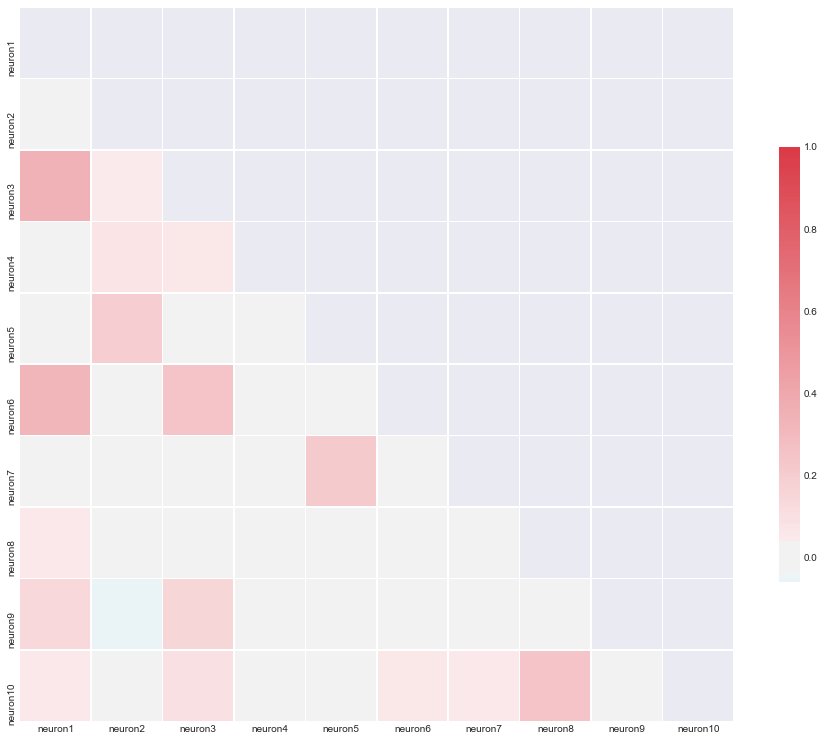

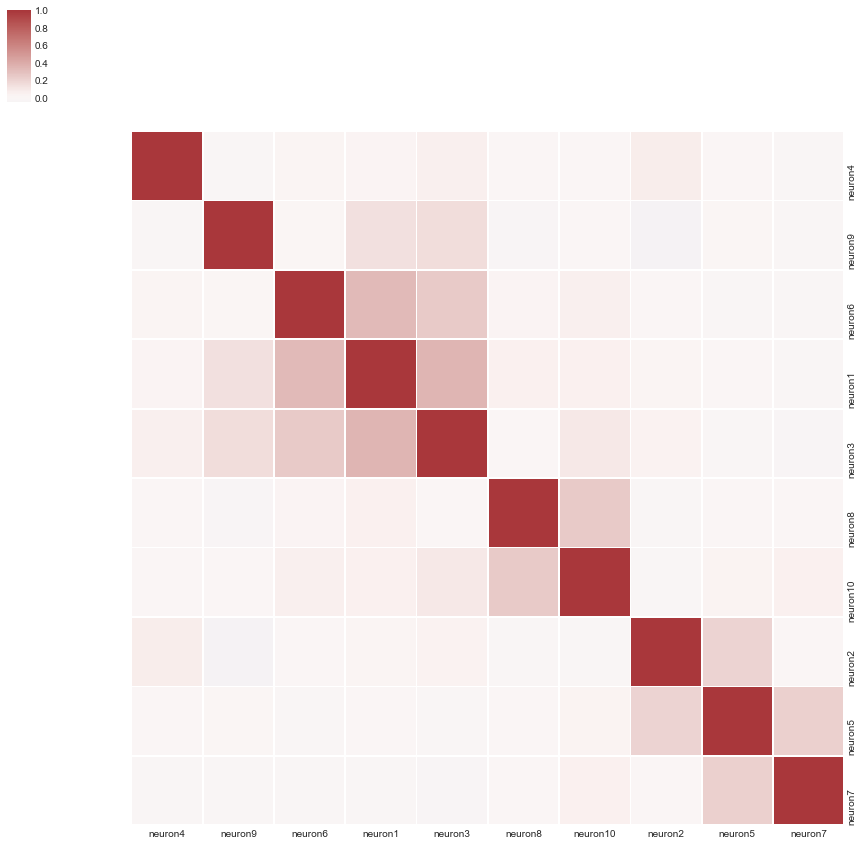

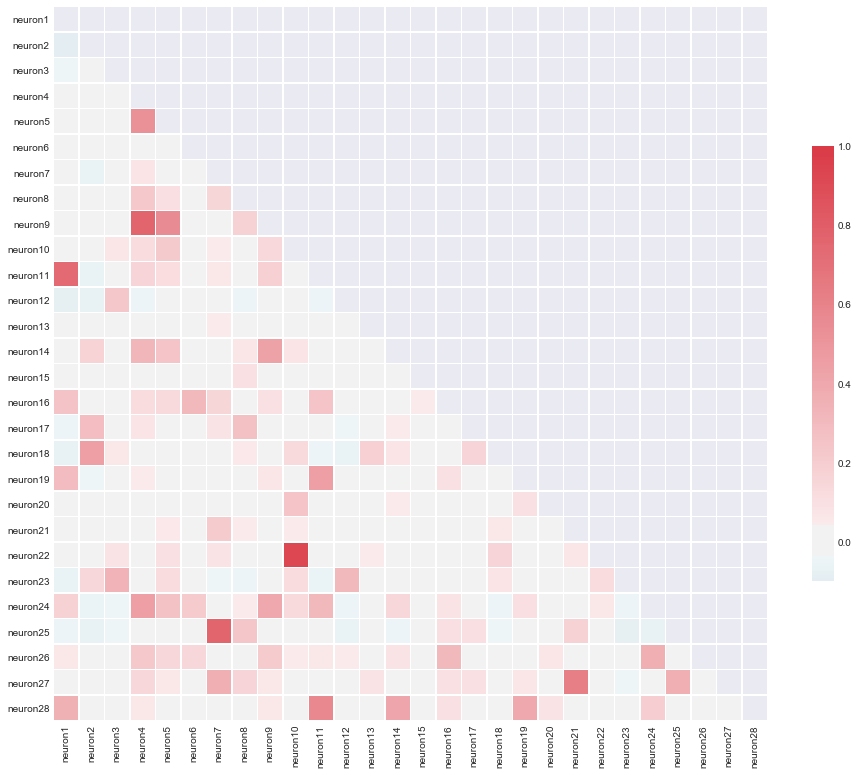

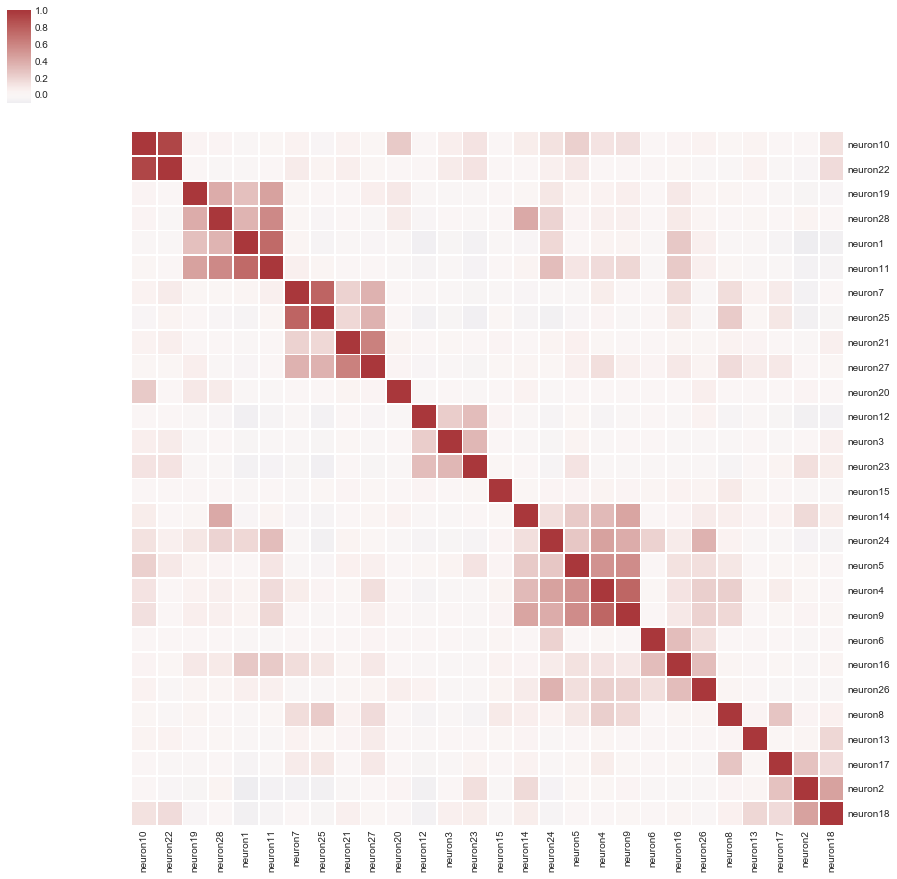

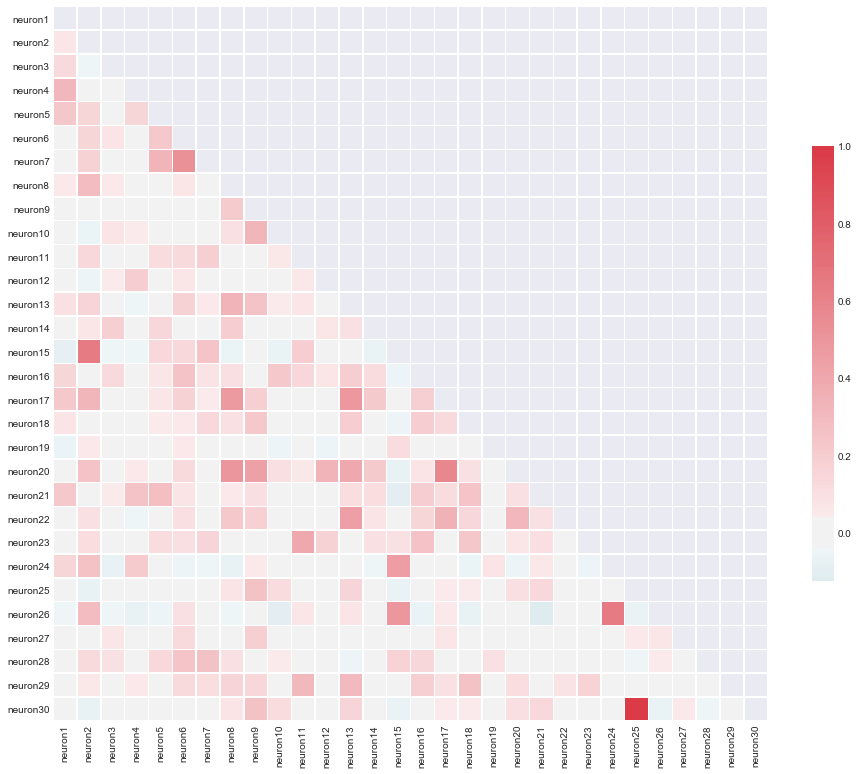

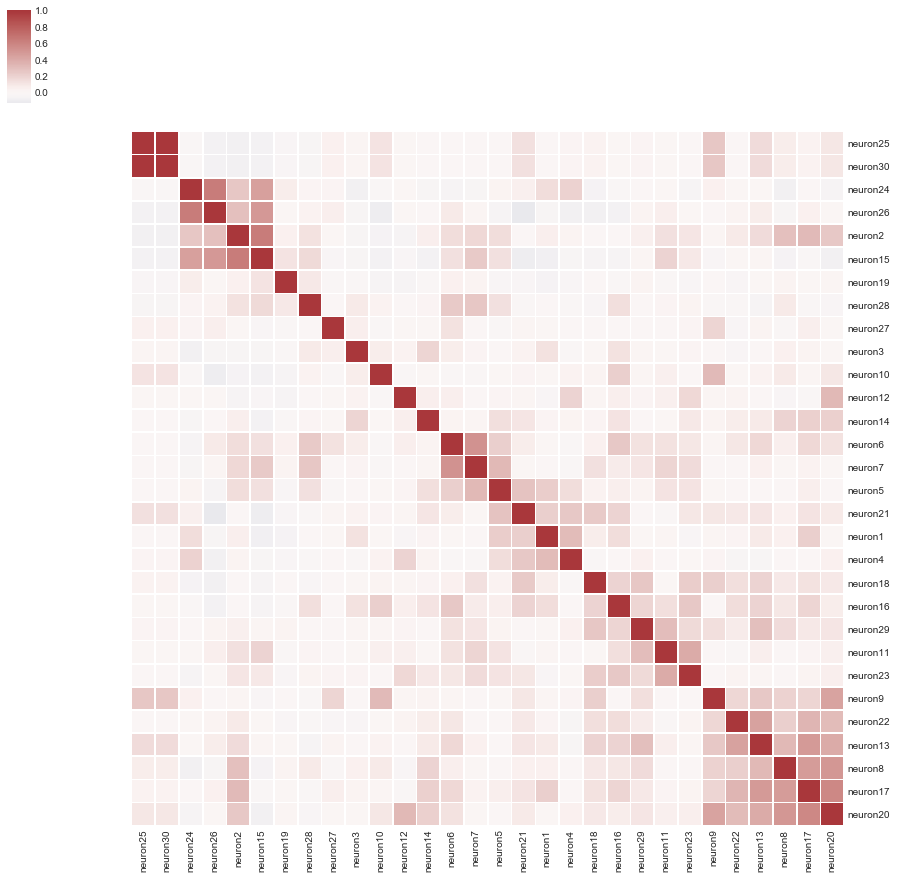

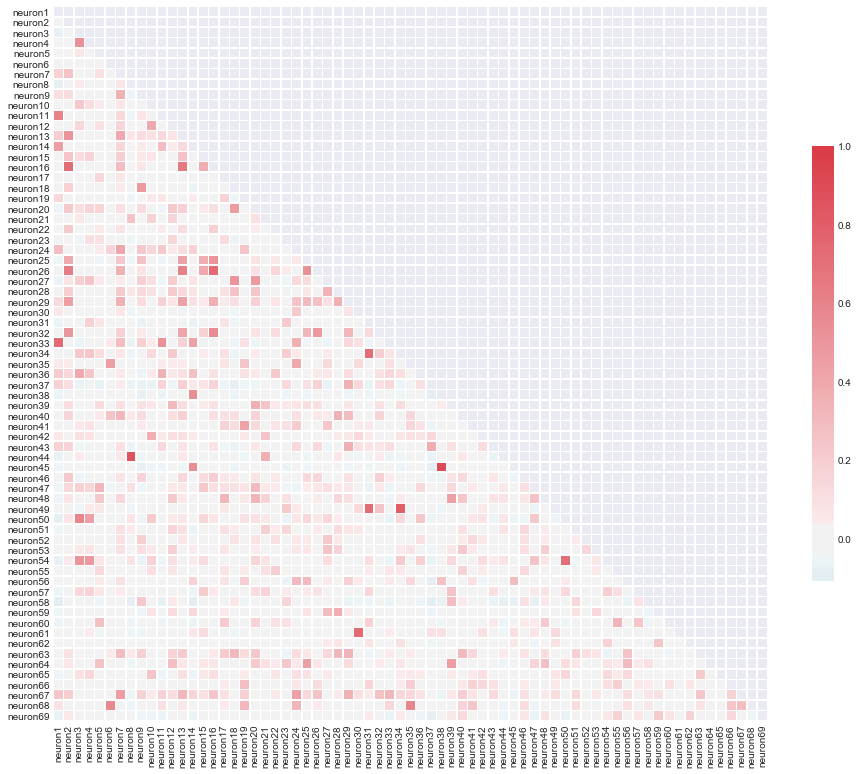

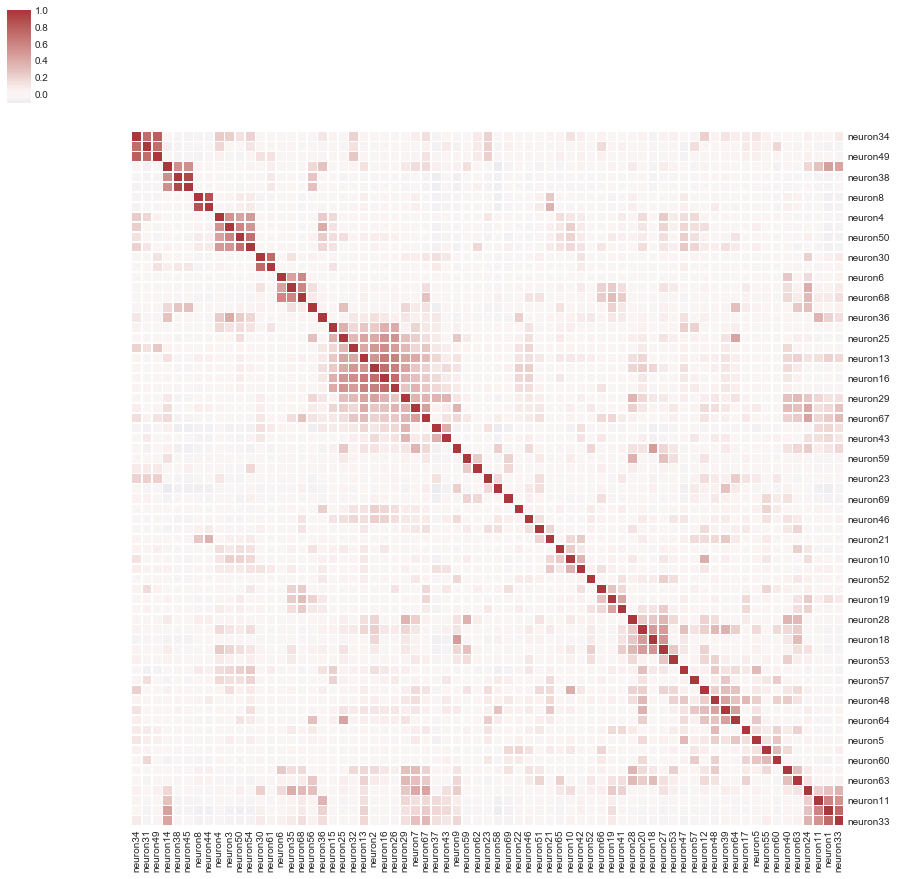

In [3]:
RAW_DRD46 = "~/Hen_Lab/Mice/drd46_experiments/Raw_EPM_drd46.csv"
RAW_DRD87 = "~/Hen_Lab/Mice/drd87_experiments/Raw_EPM_drd87.csv"

au.run_epm_analysis(raw_files)
#data = pd.read_csv(RAW_DRD87, header=None)
z_scored_dataframe, AUC_dataframe, cell_transients_dataframe = SigProc.detect_ca_transients_mossy(data, 2, 0.5, 0.2, 10)

In [ ]:
fig, r_value = au.neuron_scatter_plot_with_reg("neuron38", "neuron45", cell_transients_dataframe)
print("Correlation(neuron38, neuron45) = {}".format(r_value))
au.neuron_line_plot("neuron38", "neuron45", cell_transients_dataframe)

### We create a clustermap of all the neurons in the cell transients dataframe using the centroid method, 
$$dist(s,t)= \mid\mid c_s - c_t \mid\mid_2$$
##### where $c_s$ and $c_t$ are the centroids of clusters and $s$ and $t$, respecitvely. When two clusters $s$ and $t$ are combined into a new cluster $u$ the new centroid is computed over all the original objects in clusters $s$ and $t$. The distance then becomes the Euclidean distance between the centroid of $u$ and the centroid of a remaining cluster $v$ in the forest.

##### https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

In [ ]:
au.plot_clustermap(cell_transients_dataframe, size=16)

## TODO: Discuss and streamline the below functionality, turn it into a function, make sure the function is sound, and move it to `analysis_utils.py`

In [ ]:
behavior_column_names = ['Trial_time', 'Recording_time', 'X_center', 'Y_center', 'Area', 'Areachange', 
                         'Elongation', 'Distance_moved', 'Velocity', 'Arena_centerpoint',
                         'Open1_centerpoint', 'Open2_centerpoint',
                         'Closed1_centerpoint', 'Closed2_centerpoint',
                         'OpenArms_centerpoint', 'ClosedArms_centerpoint', 'Result_1']

activity_df = pd.read_csv('/Users/saveliyyusufov/Hen_Lab/Mice/drd87_experiments/activity_drd87.csv', header=None)
behavior_df = pd.read_csv('/Users/saveliyyusufov/Hen_Lab/Mice/drd87_experiments/behavior_drd87.csv', header=None)

# Save only every nth row in order to downsample behavior Dataframes from 30fps -> 10fps
ROW_MULTIPLE = 3
behavior_df.drop(behavior_df.index[[i for i in range(0, len(behavior_df.index)) if i % ROW_MULTIPLE != 0]], inplace=True)

# For the activity Dataframe, we Change column names to corresponding neuron names 
activity_df.columns = ['neuron' + str(i) for i in range(1, len(activity_df.columns)+1)]

# Change column names to the behavior column names found in the MossyEPM, MATLAB struct
behavior_df.columns = behavior_column_names

# Fix indexing after downsample
behavior_df.reset_index(drop=True, inplace=True)

# Make the behavior Dataframe indexed by Recording time
# behavior_df.set_index('Recording time', inplace=True)

# Make the behavior Dataframe and the activity Dataframe have the same amount of rows 
if len(behavior_df.index) > len(activity_df.index):
    diff = len(behavior_df.index) - len(activity_df.index)
    behavior_df = behavior_df[:-diff]
elif len(behavior_df.index) < len(activity_df.index):
    diff = len(activity_df.index) - len(behavior_df.index)
    activity_df = activity_df[:-diff]

# Define running frames
VELOCITY_CUTOFF = 4;

# Adds column to the end of the behavior Dataframe and make each cell in that column a 0 
# if the corresponding velocity < VELOCITY_CUTOFF or a 1 if the corresponding velocity >= VELOCITY_CUTOFF
behavior_df['Running_frames'] = [1 if velocity > VELOCITY_CUTOFF else 0 for velocity in behavior_df['Velocity'].tolist()]

result_dataframe = pd.concat([cell_transients_dataframe, behavior_df], axis=1)

## One can utilize `plot_neurons_as_function_of_beh()` from `analysis_utils.py` to explore the relationship between two given neurons as a function of some behavior as follows:

In [ ]:
au.plot_neurons_as_function_of_beh(result_dataframe, "neuron38", "neuron45", "Closed1_centerpoint", size_of_plot=6)
au.plot_neurons_as_function_of_beh(result_dataframe, "neuron38", "neuron45", "Closed2_centerpoint", size_of_plot=6)

## TODO: Make sure implementation of `compute_d_rate()` is sound, write-up documentation, and it move to `analysis_utils.py`

In [ ]:
def compute_d_rate(dataframe, neuron_activity_df, *behaviors):
    """ Computes d rate... 
    
    Args:
    
    Returns:
    """
    
    FRAME_RATE=10
    if len(behaviors) == 1:  
        beh_vec = dataframe.loc[dataframe[behaviors[0]] != 0, neuron_activity_df.columns]
        no_beh_vec = dataframe.loc[dataframe[behaviors[0]] == 0, neuron_activity_df.columns]
        return FRAME_RATE * (beh_vec.values.mean(axis=0) - no_beh_vec.values.mean(axis=0))
    elif len(behaviors) == 2:
        beh_vec = dataframe.loc[dataframe[behaviors[0]] != 0, neuron_activity_df.columns]
        no_beh_vec = dataframe.loc[dataframe[behaviors[1]] != 0, neuron_activity_df.columns]
        return FRAME_RATE * (beh_vec.values.mean(axis=0) - no_beh_vec.values.mean(axis=0))

In [ ]:
# result_dataframe.loc[result_dataframe["OpenArms_centerpoint"] != 0]
# result_dataframe.loc[result_dataframe["ClosedArms_centerpoint"] != 0]

# test_compute_d_rate(result_dataframe, cell_transients_dataframe, "OpenArms_centerpoint", "ClosedArms_centerpoint")
compute_d_rate(result_dataframe, cell_transients_dataframe, "Running_frames")

## TODO: Once all neuron (cell) selectivity code is proven to be sound, write-up documentation for `set_real_d_df()` and move it to `analysis_utils.py`

In [ ]:
def set_real_d_df(dataframe, neuron_activity_df, behavior):
    """ Create dataframe of real $d$ values for all neurons
    
    Args:
    
    Returns:
    """
    real_df = pd.DataFrame(columns=neuron_activity_df.columns, index=["d"])
    real_df.loc['d'] = compute_d_rate(dataframe, neuron_activity_df, behavior)
    return real_df

In [ ]:
real_d_df = set_real_d_df(result_dataframe, cell_transients_dataframe, "Running_frames")
real_d_df

In [ ]:
def shuffle_worker(q, n, neuron_activity_df, mouse_behavior_df, behavior):
    """ Homebrewed bootstrapping function for EPM Analysis

    Bootstrapping function that allows estimation of the sample distribution
    using cyclical shifting of the index of a pandas dataframe.

    Args:
        n: the number of random shuffles to be performed on the given data
        neuron_activity_df: the neuron activity dataframe for a given mouse
        mouse_behavior_df: the behavior dataframe for a given mouse 
        (must directly correspond with neuron_activity_df)
        behavior: the behavior to be estimated

    Returns:
        A Pandas DataFrame that contains all the neuron and behavior
        data after all the data has been bootstraped
    """ 
    shifted_beh_df = mouse_behavior_df.copy()
    shuffled_df = pd.DataFrame(columns=neuron_activity_df.columns, index=range(1, n+1))
    for row in shuffled_df.itertuples():
        shifted_beh_df.set_index(np.roll(mouse_behavior_df.index, random.randrange(1, len(mouse_behavior_df.index))), inplace=True)
        shifted_df = pd.concat([neuron_activity_df, shifted_beh_df], axis=1)
        shuffled_df.loc[row.Index] = compute_d_rate(shifted_df, neuron_activity_df, behavior)

    q.put(shuffled_df)

In [ ]:
def shuffle(iterations, neuron_activity_df, mouse_behavior_df, behavior):
    """
    This function...
    
    Args:
    
    Returns:
    """
    NUM_OF_ROWS = int(iterations / 10)
    q = Queue()
    processes = []
    rets = []
    for _ in range(0, 10):
        p = Process(target=shuffle_worker, args=(q, NUM_OF_ROWS, neuron_activity_df, mouse_behavior_df, behavior))
        processes.append(p)
        p.start()
    for p in processes:
        ret = q.get() # will block
        rets.append(ret)
    for p in processes:
        p.join()

    return pd.concat(rets, ignore_index=True)

In [ ]:
import time
s = time.time()
bootstrapped = shuffle(10000, cell_transients_dataframe, behavior_df, "Running_frames")
e = time.time()
print(e-s)

In [ ]:
bootstrapped

In [ ]:
sns.distplot(bootstrapped["neuron19"].tolist(), color='m', fit=stats.norm);

## TODO: in addition to classifying the neurons, should there be a way to see the distribution plot for each neuron? (To see how well the bootstrapping worked and etc.)

## TODO: for `is_neuron_selective()`, make sure implementation is sound, write-up documentation, and move to analysis_utils.py

In [ ]:
def is_neuron_selective(bootstrapped_df, real_d_df, neuron, behavior_name, hi_percentile, lo_percentile):
    """ Classifies a given neuron as selective or non-selective
    
    Args:
    
    Returns:
    """
    # print("{} percentile of {} is {},   d_value of {} is {}".format(hi_percentile, neuron, np.percentile(bootstrapped[neuron], 87), neuron, real_d_df[neuron]['d']))
    if real_d_df[neuron]['d'] >= np.percentile(bootstrapped_df[neuron], hi_percentile):
        return behavior_name
    elif real_d_df[neuron]['d'] <= np.percentile(bootstrapped_df[neuron], lo_percentile):
        return "Non-" + behavior_name
    else: 
        return "Non-selective"

In [ ]:
is_neuron_selective(bootstrapped, real_d_df, "neuron42", "Running", 87.5, 5)

## TODO: For `classify_neurons_for_beh()`, make sure implementation is sound, write-up documentation, and move to analysis_utils.py

In [ ]:
def classify_neurons_for_beh(bootstrapped_df, real_d_df, neuron, behavior_name, hi_percentile, lo_percentile):
    """ Classifies all neurons for one mouse as either selective or non-selective
    
    Args:
    
    Returns:
    """
    neurons_dict = {}
    for neuron in bootstrapped_df.columns:
        neurons_dict[neuron] = is_neuron_selective(bootstrapped_df, real_d_df, neuron, behavior_name, hi_percentile, lo_percentile)

    return neurons_dict

In [ ]:
classify_neurons_for_beh(bootstrapped, real_d_df, "neuron42", "Running", 87.5, 5)

## TODO: discuss the purpose of `activity_by_neurons()` and `load_Activities_DataFrame()` in order to write up documentation for them.

In [ ]:
au.load_activities_dataframe(result_dataframe, cell_transients_dataframe)